### After presenting some results at sibiu, 
the following (convergence vs time) were suggested to justify the cost of the time

In [1]:
import os
os.environ["JAX_ENABLE_X64"] = "true"
import sys
sys.path.append('..')
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from jax import config
from jax import vmap
import time

config.update("jax_enable_x64", True)
import scienceplots
plt.style.use(['science','ieee'])

float64


Next, we update the method to have 256 spatial resolution, as to mimimise spatial errors.
We choose $dt = (10^{-5}) i$, for $i=1,...,1/16$. $T_{max} = 0.1$. 

In [2]:
key1 = jax.random.PRNGKey(0)
i=8
nmax = int(1e4 * 2**i) #10000
tmax = 0.1 # 0.1 timestep
dt = 1e-5*(1/2)**i # tmax/nmax
E=1; P=1
dW = jax.random.normal(key1, shape=(nmax, E, P))
print(dW.shape)

dW_refine = []; W_refine = []; time_refine = []
for l in range(0, i+1):
    nmax = int(1e4 * 2**(l))# the initial one is at lowest resolution 
    time_refine.append( jnp.linspace(0, tmax, nmax) )
    dW_refine.append(dW)
    W_refine.append(jnp.cumsum(dW, axis=0))
    dW = (dW + jnp.roll(dW, -1, axis=0))[::2, :, :]
dW_refine.reverse()
W_refine.reverse()
#time_refine.reverse()
print(nmax,len(time_refine[0]),len(W_refine[0]))
print(len(time_refine[-1]),len(W_refine[-1]))

@jax.jit
def relative_error_final(signal_final, analytic_final):
    return jnp.linalg.norm(signal_final-analytic_final)/jnp.linalg.norm(analytic_final)

array = jnp.zeros(8)
nmax = int(1e4 * 2**i) 
print(int(1e4),nmax)
tmax = 0.1 
dt = 1e-5*(1/2)**i
key = jax.random.PRNGKey(0)

(2560000, 1, 1)
2560000 10000 10000
2560000 2560000
10000 2560000


In [ ]:
methods = ['Dealiased_IFSRK4','Dealiased_SETDRK4','Dealiased_SRK4']
max_number = 14
array = jnp.zeros([len(methods),max_number])
cpu_times_array = jnp.zeros([len(methods),max_number])

total_array = jnp.zeros([9,max_number])
total_cpu_array = jnp.zeros([9,max_number])# 9 methods, 9 
key = jax.random.PRNGKey(0)
nmax = int(1e2 * 2**max_number)# highest resolution is 100 2^{16} timestes
tmax = 0.1 
dt = 1e-3*(1/2)**max_number
assert dt*nmax == tmax, "dt*nmax must equal tmax for the setup to be correct."
E=1; P=1
dW = jax.random.normal(key, shape=(nmax, E, P))

@jax.jit
def relative_error_final(signal_final, analytic_final):
    return jnp.linalg.norm(signal_final-analytic_final)/jnp.linalg.norm(analytic_final)

dW_refine = []; W_refine = []; time_refine = []
for l in range(0,max_number+1):
    nmax = int(1e2 * 2**(l))# the initial one is at lowest resolution 
    time_refine.append( jnp.linspace(0, tmax, nmax) )
    dW_refine.append(dW)
    W_refine.append(jnp.cumsum(dW, axis=0))
    dW = (dW + jnp.roll(dW, -1, axis=0))[::2, :, :]
dW_refine.reverse()
W_refine.reverse()

for j, method in enumerate(methods):
    for i in range(max_number):
        print(i,method)
        signal_params = ConfigDict(KDV_params_exact_traveling)
        signal_params.update(E=1,method=method,dt= 1e-3*(1/2)**i, nt = int(1e2 * 2**i),tmax=0.1,nx=256,P=1,S=0,noise_magnitude=1, initial_condition = 'very_steep_traveling_wave')
        signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
        initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
        dW =(dW_refine[i]/jnp.sqrt(2**(max_number-i))) # renormalise. from the refined dW created.
        
        num_runs = 5
        times = []
        for _ in range(num_runs):
            start = time.time()
            _ = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key).block_until_ready()
            times.append(time.time() - start)
        avg_time = sum(times) / num_runs
        print(f"Average CPU time for i={i}: {avg_time:.4f} seconds")
        # Save to an array indexed by i
        cpu_times_array = cpu_times_array.at[j,i].set(avg_time)
        signal_final = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key) #the final input is scan length? 
        
        W = jnp.cumsum(dW, axis=0)
        W = jnp.sqrt(signal_model.params.dt) * signal_model.params.noise_magnitude * W
        W_new = jnp.zeros([signal_model.params.nt+1, signal_model.params.E, signal_model.params.P])
        W_new = W_new.at[1:,:,:].set(W)

        E = signal_model.params.E
        nmax = signal_model.params.nt
        nx = signal_model.params.nx
        x = signal_model.x
        xmax = signal_model.params.xmax
        xmin = signal_model.params.xmin
        dt = signal_model.params.dt

        initial_condition_jitted = jax.jit(initial_condition, static_argnums=(1,2))# jitted with last two arguments frozen
        def compute_ans(n, x, dt, W_new, xmax, E, initial_condition):
            return initial_condition_jitted((x - 9 * 9 * (dt * n) - W_new[n, :, :] + xmax) % (xmax * 2) - xmax, E, signal_params.initial_condition)

        analytic_final = compute_ans(nmax, x, dt, W_new, xmax, E, signal_params.initial_condition)
    
        array = array.at[j,i].set(relative_error_final(signal_final[-1, :], analytic_final[-1, :]))
        del signal_model
for j in range(len(methods)):
    total_array = total_array.at[j,:].set(array[j,:])
    total_cpu_array = total_cpu_array.at[j,:].set(cpu_times_array[j,:])
# this takes upto 2 mins due to total number of timesteps being 3 sum_{i=1}^{i=14} (100*2^{i}) at space resolution 256

0 Dealiased_IFSRK4
Average CPU time for i=0: 0.0697 seconds
1 Dealiased_IFSRK4
Average CPU time for i=1: 0.0694 seconds
2 Dealiased_IFSRK4
Average CPU time for i=2: 0.0724 seconds
3 Dealiased_IFSRK4
Average CPU time for i=3: 0.0845 seconds
4 Dealiased_IFSRK4
Average CPU time for i=4: 0.0949 seconds
5 Dealiased_IFSRK4
Average CPU time for i=5: 0.1254 seconds
6 Dealiased_IFSRK4
Average CPU time for i=6: 0.1814 seconds
7 Dealiased_IFSRK4
Average CPU time for i=7: 0.3022 seconds
8 Dealiased_IFSRK4
Average CPU time for i=8: 0.5272 seconds
9 Dealiased_IFSRK4
Average CPU time for i=9: 0.9977 seconds
10 Dealiased_IFSRK4
Average CPU time for i=10: 1.8915 seconds
11 Dealiased_IFSRK4
Average CPU time for i=11: 3.7523 seconds
12 Dealiased_IFSRK4
Average CPU time for i=12: 7.4057 seconds
13 Dealiased_IFSRK4
Average CPU time for i=13: 15.0392 seconds
0 Dealiased_SETDRK4
Average CPU time for i=0: 0.0597 seconds
1 Dealiased_SETDRK4
Average CPU time for i=1: 0.0627 seconds
2 Dealiased_SETDRK4
Average C

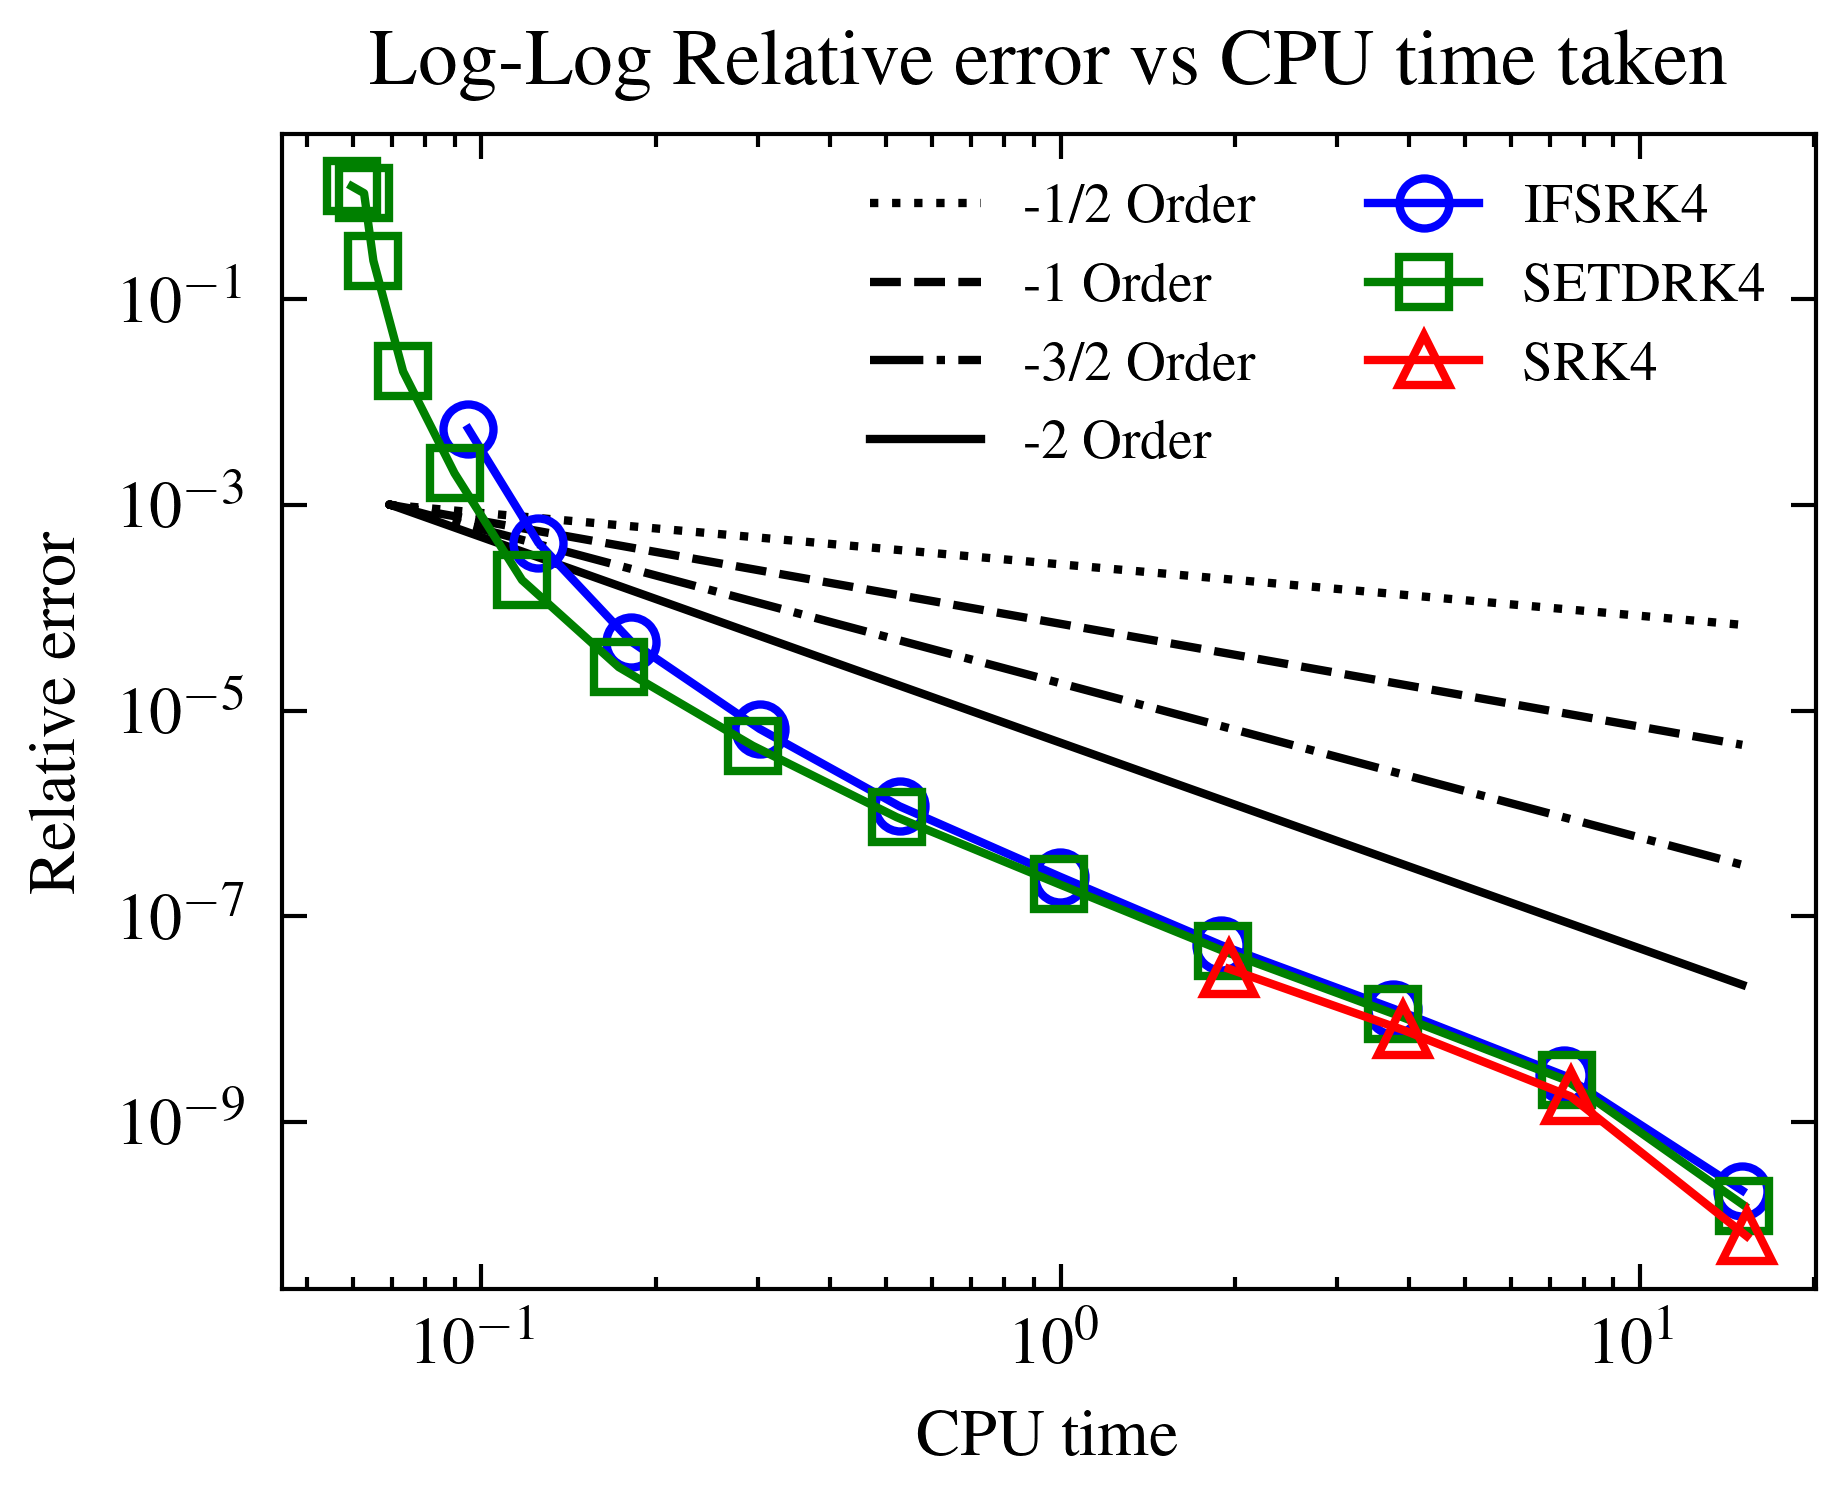

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])

values = array
values = array
a = cpu_times_array[0,0]
v= 1e-3
plt.figure()
# Mask values greater than 1 before plotting
# values = np.where(values > 2, np.nan, values)
plt.loglog(cpu_times_array[0,:],(cpu_times_array[0,:]**-0.5)/(a**-0.5)*v, linestyle=':', color='k', label=r'-1/2 Order')
plt.loglog(cpu_times_array[0,:],(cpu_times_array[0,:]**-1)/(a**-1)*v, linestyle='--', color='k', label=r'-1 Order')
plt.loglog(cpu_times_array[0,:],(cpu_times_array[0,:]**-1.5)/(a**-1.5)*v, linestyle='-.', color='k', label=r'-3/2 Order')
plt.loglog(cpu_times_array[0,:],(cpu_times_array[0,:]**-2)/(a**-2)*v, linestyle='-', color='k', label=r'-2 Order')

marker_list = ['o', 's', '^', 'D', 'v', 'x', '+', '*', 'p', 'H', 'd', 'X']
color_list = ['b', 'g', 'r', 'c', 'm', 'y']
methods = ['Dealiased_IFSRK4','Dealiased_SETDRK4','Dealiased_SRK4']

# In matplotlib, the marker for an upward-pointing triangle is '^'
for j, method in enumerate(methods):
    marker = marker_list[j % len(marker_list)]
    color = color_list[j % len(color_list)]
    plt.loglog(cpu_times_array[j,:], total_array[j, :], marker=marker,color=color, linestyle='-', label=f'{method.replace("Dealiased_", "")}', markerfacecolor='none')

plt.xlabel(f'CPU time')
plt.ylabel('Relative error')
plt.title('Log-Log Relative error vs CPU time taken')
plt.legend()
plt.legend(fontsize='small', loc='best', ncol=2)
#plt.grid(True, which="both", ls="--")
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/EX5_cpu_error_RK4_IFRK4_ETDRK4.png',bbox_inches='tight',dpi=300)
plt.show()

In [8]:
methods = ['Dealiased_eSSPIFSRK_P_33','Dealiased_SETDRK33','Dealiased_SSP33']
max_number = 14
array = jnp.zeros([len(methods),max_number])
cpu_times_array_2 = jnp.zeros([len(methods),max_number])
key = jax.random.PRNGKey(0)
nmax = int(1e2 * 2**max_number)
tmax = 0.1
dt = 1e-3*(1/2)**max_number
assert dt*nmax == tmax, "dt*nmax must equal tmax for the setup to be correct."
E=1; P=1
dW = jax.random.normal(key, shape=(nmax, E, P))

@jax.jit
def relative_error_final(signal_final, analytic_final):
    return jnp.linalg.norm(signal_final-analytic_final)/jnp.linalg.norm(analytic_final)

dW_refine = []; W_refine = []; time_refine = []
for l in range(0,max_number+1):
    nmax = int(1e2 * 2**(l))# the initial one is at lowest resolution 
    time_refine.append( jnp.linspace(0, tmax, nmax) )
    dW_refine.append(dW)
    W_refine.append(jnp.cumsum(dW, axis=0))
    dW = (dW + jnp.roll(dW, -1, axis=0))[::2, :, :]
dW_refine.reverse()
W_refine.reverse()



for j, method in enumerate(methods):
    for i in range(max_number):
        print(i,method)
        signal_params = ConfigDict(KDV_params_exact_traveling)
        signal_params.update(E=1,method=method,dt= 1e-3*(1/2)**i, nt = int(1e2 * 2**i),tmax=0.1,nx=256,P=1,S=0,noise_magnitude=1.0, initial_condition = 'very_steep_traveling_wave')
        signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
        initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
        dW =(dW_refine[i]/jnp.sqrt(2**(max_number-i))) # renormalise. from the refined dW created.
        
        num_runs = 5
        times = []
        for _ in range(num_runs):
            start = time.time()
            _ = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key).block_until_ready()
            times.append(time.time() - start)
        avg_time = sum(times) / num_runs
        print(f"Average CPU time for i={i}: {avg_time:.4f} seconds")
        # Save to an array indexed by i
        cpu_times_array_2 = cpu_times_array_2.at[j,i].set(avg_time)
        signal_final = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key) #the final input is scan length? 
        W = jnp.cumsum(dW, axis=0)
        W = jnp.sqrt(signal_model.params.dt) * signal_model.params.noise_magnitude * W
        W_new = jnp.zeros([signal_model.params.nt+1, signal_model.params.E, signal_model.params.P])
        W_new = W_new.at[1:,:,:].set(W)

        E = signal_model.params.E
        nmax = signal_model.params.nt
        nx = signal_model.params.nx
        x = signal_model.x
        xmax = signal_model.params.xmax
        xmin = signal_model.params.xmin
        dt = signal_model.params.dt

        initial_condition_jitted = jax.jit(initial_condition, static_argnums=(1,2))# jitted with last two arguments frozen
        def compute_ans(n, x, dt, W_new, xmax, E, initial_condition):
            return initial_condition_jitted((x - 9 * 9 * (dt * n) - W_new[n, :, :] + xmax) % (xmax * 2) - xmax, E, signal_params.initial_condition)

        analytic_final = compute_ans(nmax, x, dt, W_new, xmax, E, signal_params.initial_condition)
    
        array = array.at[j,i].set(relative_error_final(signal_final[-1, :], analytic_final[-1, :]))
        del signal_model

for j in range(len(methods)):
    total_array = total_array.at[j+3,:].set(array[j,:])
    total_cpu_array = total_cpu_array.at[j+3,:].set(cpu_times_array_2[j,:])


0 Dealiased_eSSPIFSRK_P_33
Average CPU time for i=0: 0.0666 seconds
1 Dealiased_eSSPIFSRK_P_33
Average CPU time for i=1: 0.0665 seconds
2 Dealiased_eSSPIFSRK_P_33
Average CPU time for i=2: 0.0698 seconds
3 Dealiased_eSSPIFSRK_P_33
Average CPU time for i=3: 0.0787 seconds
4 Dealiased_eSSPIFSRK_P_33
Average CPU time for i=4: 0.0900 seconds
5 Dealiased_eSSPIFSRK_P_33
Average CPU time for i=5: 0.1128 seconds
6 Dealiased_eSSPIFSRK_P_33
Average CPU time for i=6: 0.1608 seconds
7 Dealiased_eSSPIFSRK_P_33
Average CPU time for i=7: 0.2516 seconds
8 Dealiased_eSSPIFSRK_P_33
Average CPU time for i=8: 0.4563 seconds
9 Dealiased_eSSPIFSRK_P_33
Average CPU time for i=9: 0.8055 seconds
10 Dealiased_eSSPIFSRK_P_33
Average CPU time for i=10: 1.5326 seconds
11 Dealiased_eSSPIFSRK_P_33
Average CPU time for i=11: 2.9965 seconds
12 Dealiased_eSSPIFSRK_P_33
Average CPU time for i=12: 5.8708 seconds
13 Dealiased_eSSPIFSRK_P_33
Average CPU time for i=13: 11.8256 seconds
0 Dealiased_SETDRK33
Average CPU time f

[[           nan            nan            nan            nan
             nan            nan            nan 2.04219690e-02
  8.61473946e-03 3.98933224e-03 1.88852126e-03 9.34314072e-04
  4.60713056e-04 2.28699860e-04]
 [           nan            nan            nan 1.29432850e+00
  4.14862636e-01 1.16385889e-01 4.24932163e-02 1.76342272e-02
  7.82637610e-03 3.72147418e-03 1.78393738e-03 8.88846586e-04
  4.39706553e-04 2.18613942e-04]
 [           nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan]]
(3, 14)
[[           nan            nan            nan            nan
             nan            nan            nan 2.04219690e-02
  8.61473946e-03 3.98933224e-03 1.88852126e-03 9.34314072e-04
  4.60713056e-04 2.28699860e-04]
 [           nan            nan            nan 1.29432850e+00
  4.14862636e-01 1.16385889e-01 4.24932163e-02 1.7634

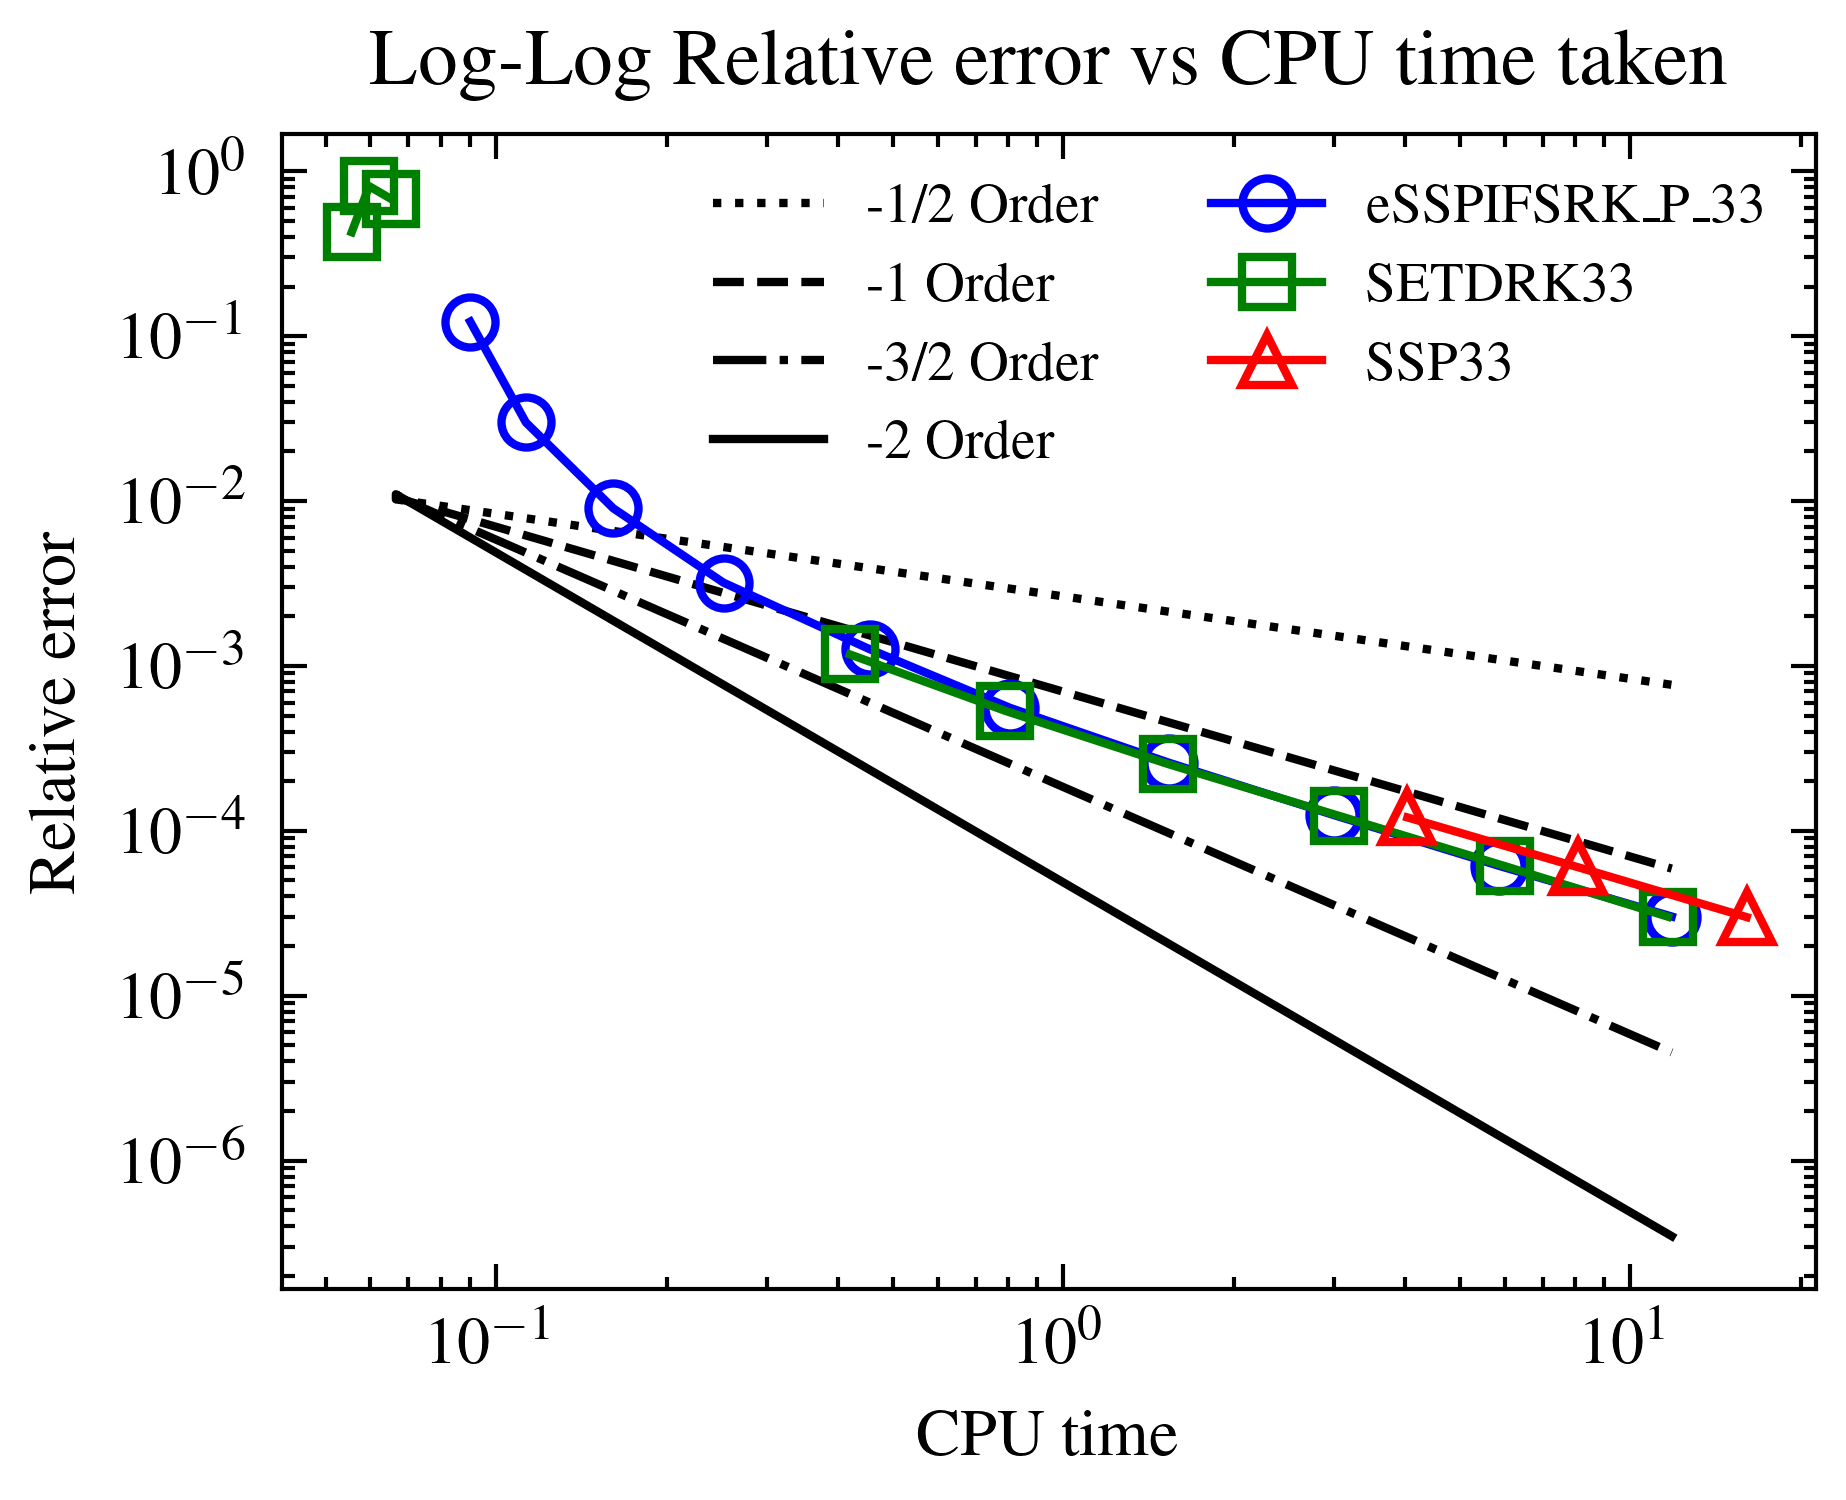

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])
#dt = cpu_times_array#1e-3*np.asarray([2**-i for i in range(0,max_number)])
methods = ['Dealiased_eSSPIFSRK_P_33','Dealiased_SETDRK33','Dealiased_SSP33']

values = array
print(values)
print(values.shape)
values = array
print(values,values.shape)
a = cpu_times_array[0,0]
v= 1e-2
plt.figure()
#plt.scatter(a,0.1, color='r', label='point')
# Mask values greater than 1 before plotting
# values = np.where(values > 2, np.nan, values)
plt.loglog(cpu_times_array_2[0,:],(cpu_times_array_2[0,:]**-0.5)/(a**-0.5)*v, linestyle=':', color='k', label=r'-1/2 Order')
plt.loglog(cpu_times_array_2[0,:],(cpu_times_array_2[0,:]**-1)/(a**-1)*v, linestyle='--', color='k', label=r'-1 Order')
plt.loglog(cpu_times_array_2[0,:],(cpu_times_array_2[0,:]**-1.5)/(a**-1.5)*v, linestyle='-.', color='k', label=r'-3/2 Order')
plt.loglog(cpu_times_array_2[0,:],(cpu_times_array_2[0,:]**-2)/(a**-2)*v, linestyle='-', color='k', label=r'-2 Order')

marker_list = ['o', 's', '^', 'D', 'v', 'x', '+', '*', 'p', 'H', 'd', 'X']
color_list = ['b', 'g', 'r', 'c', 'm', 'y']
# In matplotlib, the marker for an upward-pointing triangle is '^'
for j, method in enumerate(methods):
    marker = marker_list[j % len(marker_list)]
    color = color_list[j % len(color_list)]
    plt.loglog(cpu_times_array_2[j,:], total_array[j+3, :], marker=marker,color=color, linestyle='-', label=f'{method.replace("Dealiased_", "")}', markerfacecolor='none')

plt.xlabel(f'CPU time')
plt.ylabel('Relative error')
plt.title('Log-Log Relative error vs CPU time taken')
#plt.grid(True, which="both", ls="--")
plt.legend()
plt.legend(fontsize='small', loc='best', ncol=2)
#plt.grid(True, which="both", ls="--")
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/EX5_cpu_error_SSP33_IFRK3_SETDRK3.png',bbox_inches='tight',dpi=300)
plt.show()

In [10]:
methods = ['Dealiased_eSSPIFSRK_P_22','Dealiased_SETDRK22','Dealiased_SSP22']
max_number = 14
array = jnp.zeros([len(methods),max_number])
cpu_times_array_3 = jnp.zeros([len(methods),max_number])
key = jax.random.PRNGKey(0)
nmax = int(1e2 * 2**max_number)
tmax = 0.1 
dt = 1e-3*(1/2)**max_number
assert dt*nmax == tmax, "dt*nmax must equal tmax for the setup to be correct."
E=1; P=1
dW = jax.random.normal(key, shape=(nmax, E, P))

@jax.jit
def relative_error_final(signal_final, analytic_final):
    return jnp.linalg.norm(signal_final-analytic_final)/jnp.linalg.norm(analytic_final)

dW_refine = []; W_refine = []; time_refine = []
for l in range(0,max_number+1):
    nmax = int(1e2 * 2**(l))# the initial one is at lowest resolution 
    time_refine.append( jnp.linspace(0, tmax, nmax) )
    dW_refine.append(dW)
    W_refine.append(jnp.cumsum(dW, axis=0))
    dW = (dW + jnp.roll(dW, -1, axis=0))[::2, :, :]
dW_refine.reverse()
W_refine.reverse()



for j, method in enumerate(methods):
    for i in range(max_number):
        print(i,method)
        signal_params = ConfigDict(KDV_params_exact_traveling)
        signal_params.update(E=1,method=method,dt= 1e-3*(1/2)**i, nt = int(1e2 * 2**i),tmax=0.1,nx=256,P=1,S=0,noise_magnitude=1.0, initial_condition = 'very_steep_traveling_wave')
        signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
        initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
        dW =(dW_refine[i]/jnp.sqrt(2**(max_number-i))) # renormalise. from the refined dW created.
        
        num_runs = 5
        times = []
        for _ in range(num_runs):
            start = time.time()
            _ = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key).block_until_ready()
            times.append(time.time() - start)
        avg_time = sum(times) / num_runs
        print(f"Average CPU time for i={i}: {avg_time:.4f} seconds")
        # Save to an array indexed by i
        cpu_times_array_3 = cpu_times_array_3.at[j,i].set(avg_time)
        signal_final = signal_model.final_time_run(initial_signal, signal_model.params.nt, dW, key) #the final input is scan length? 
        
        
        W = jnp.cumsum(dW, axis=0)
        W = jnp.sqrt(signal_model.params.dt) * signal_model.params.noise_magnitude * W
        W_new = jnp.zeros([signal_model.params.nt+1, signal_model.params.E, signal_model.params.P])
        W_new = W_new.at[1:,:,:].set(W)

        E = signal_model.params.E
        nmax = signal_model.params.nt
        nx = signal_model.params.nx
        x = signal_model.x
        xmax = signal_model.params.xmax
        xmin = signal_model.params.xmin
        dt = signal_model.params.dt

        initial_condition_jitted = jax.jit(initial_condition, static_argnums=(1,2))# jitted with last two arguments frozen
        def compute_ans(n, x, dt, W_new, xmax, E, initial_condition):
            return initial_condition_jitted((x - 9 * 9 * (dt * n) - W_new[n, :, :] + xmax) % (xmax * 2) - xmax, E, signal_params.initial_condition)

        analytic_final = compute_ans(nmax, x, dt, W_new, xmax, E, signal_params.initial_condition)
    
        array = array.at[j,i].set(relative_error_final(signal_final[-1, :], analytic_final[-1, :]))
        del signal_model

for j in range(len(methods)):
    total_array = total_array.at[j+6,:].set(array[j,:])
    total_cpu_array = total_cpu_array.at[j+3,:].set(cpu_times_array_3[j,:])


0 Dealiased_eSSPIFSRK_P_22
Average CPU time for i=0: 0.0568 seconds
1 Dealiased_eSSPIFSRK_P_22
Average CPU time for i=1: 0.0604 seconds
2 Dealiased_eSSPIFSRK_P_22
Average CPU time for i=2: 0.0572 seconds
3 Dealiased_eSSPIFSRK_P_22
Average CPU time for i=3: 0.0624 seconds
4 Dealiased_eSSPIFSRK_P_22
Average CPU time for i=4: 0.0674 seconds
5 Dealiased_eSSPIFSRK_P_22
Average CPU time for i=5: 0.0845 seconds
6 Dealiased_eSSPIFSRK_P_22
Average CPU time for i=6: 0.1192 seconds
7 Dealiased_eSSPIFSRK_P_22
Average CPU time for i=7: 0.1892 seconds
8 Dealiased_eSSPIFSRK_P_22
Average CPU time for i=8: 0.3118 seconds
9 Dealiased_eSSPIFSRK_P_22
Average CPU time for i=9: 0.5717 seconds
10 Dealiased_eSSPIFSRK_P_22
Average CPU time for i=10: 1.0762 seconds
11 Dealiased_eSSPIFSRK_P_22
Average CPU time for i=11: 2.1192 seconds
12 Dealiased_eSSPIFSRK_P_22
Average CPU time for i=12: 4.1680 seconds
13 Dealiased_eSSPIFSRK_P_22
Average CPU time for i=13: 8.3987 seconds
0 Dealiased_SETDRK22
Average CPU time fo

[[           nan            nan            nan            nan
             nan            nan            nan 2.04219690e-02
  8.61473946e-03 3.98933224e-03 1.88852126e-03 9.34314072e-04
  4.60713056e-04 2.28699860e-04]
 [           nan            nan            nan 1.29432850e+00
  4.14862636e-01 1.16385889e-01 4.24932163e-02 1.76342272e-02
  7.82637610e-03 3.72147418e-03 1.78393738e-03 8.88846586e-04
  4.39706553e-04 2.18613942e-04]
 [           nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan]]
(3, 14)
[[           nan            nan            nan            nan
             nan            nan            nan 2.04219690e-02
  8.61473946e-03 3.98933224e-03 1.88852126e-03 9.34314072e-04
  4.60713056e-04 2.28699860e-04]
 [           nan            nan            nan 1.29432850e+00
  4.14862636e-01 1.16385889e-01 4.24932163e-02 1.7634

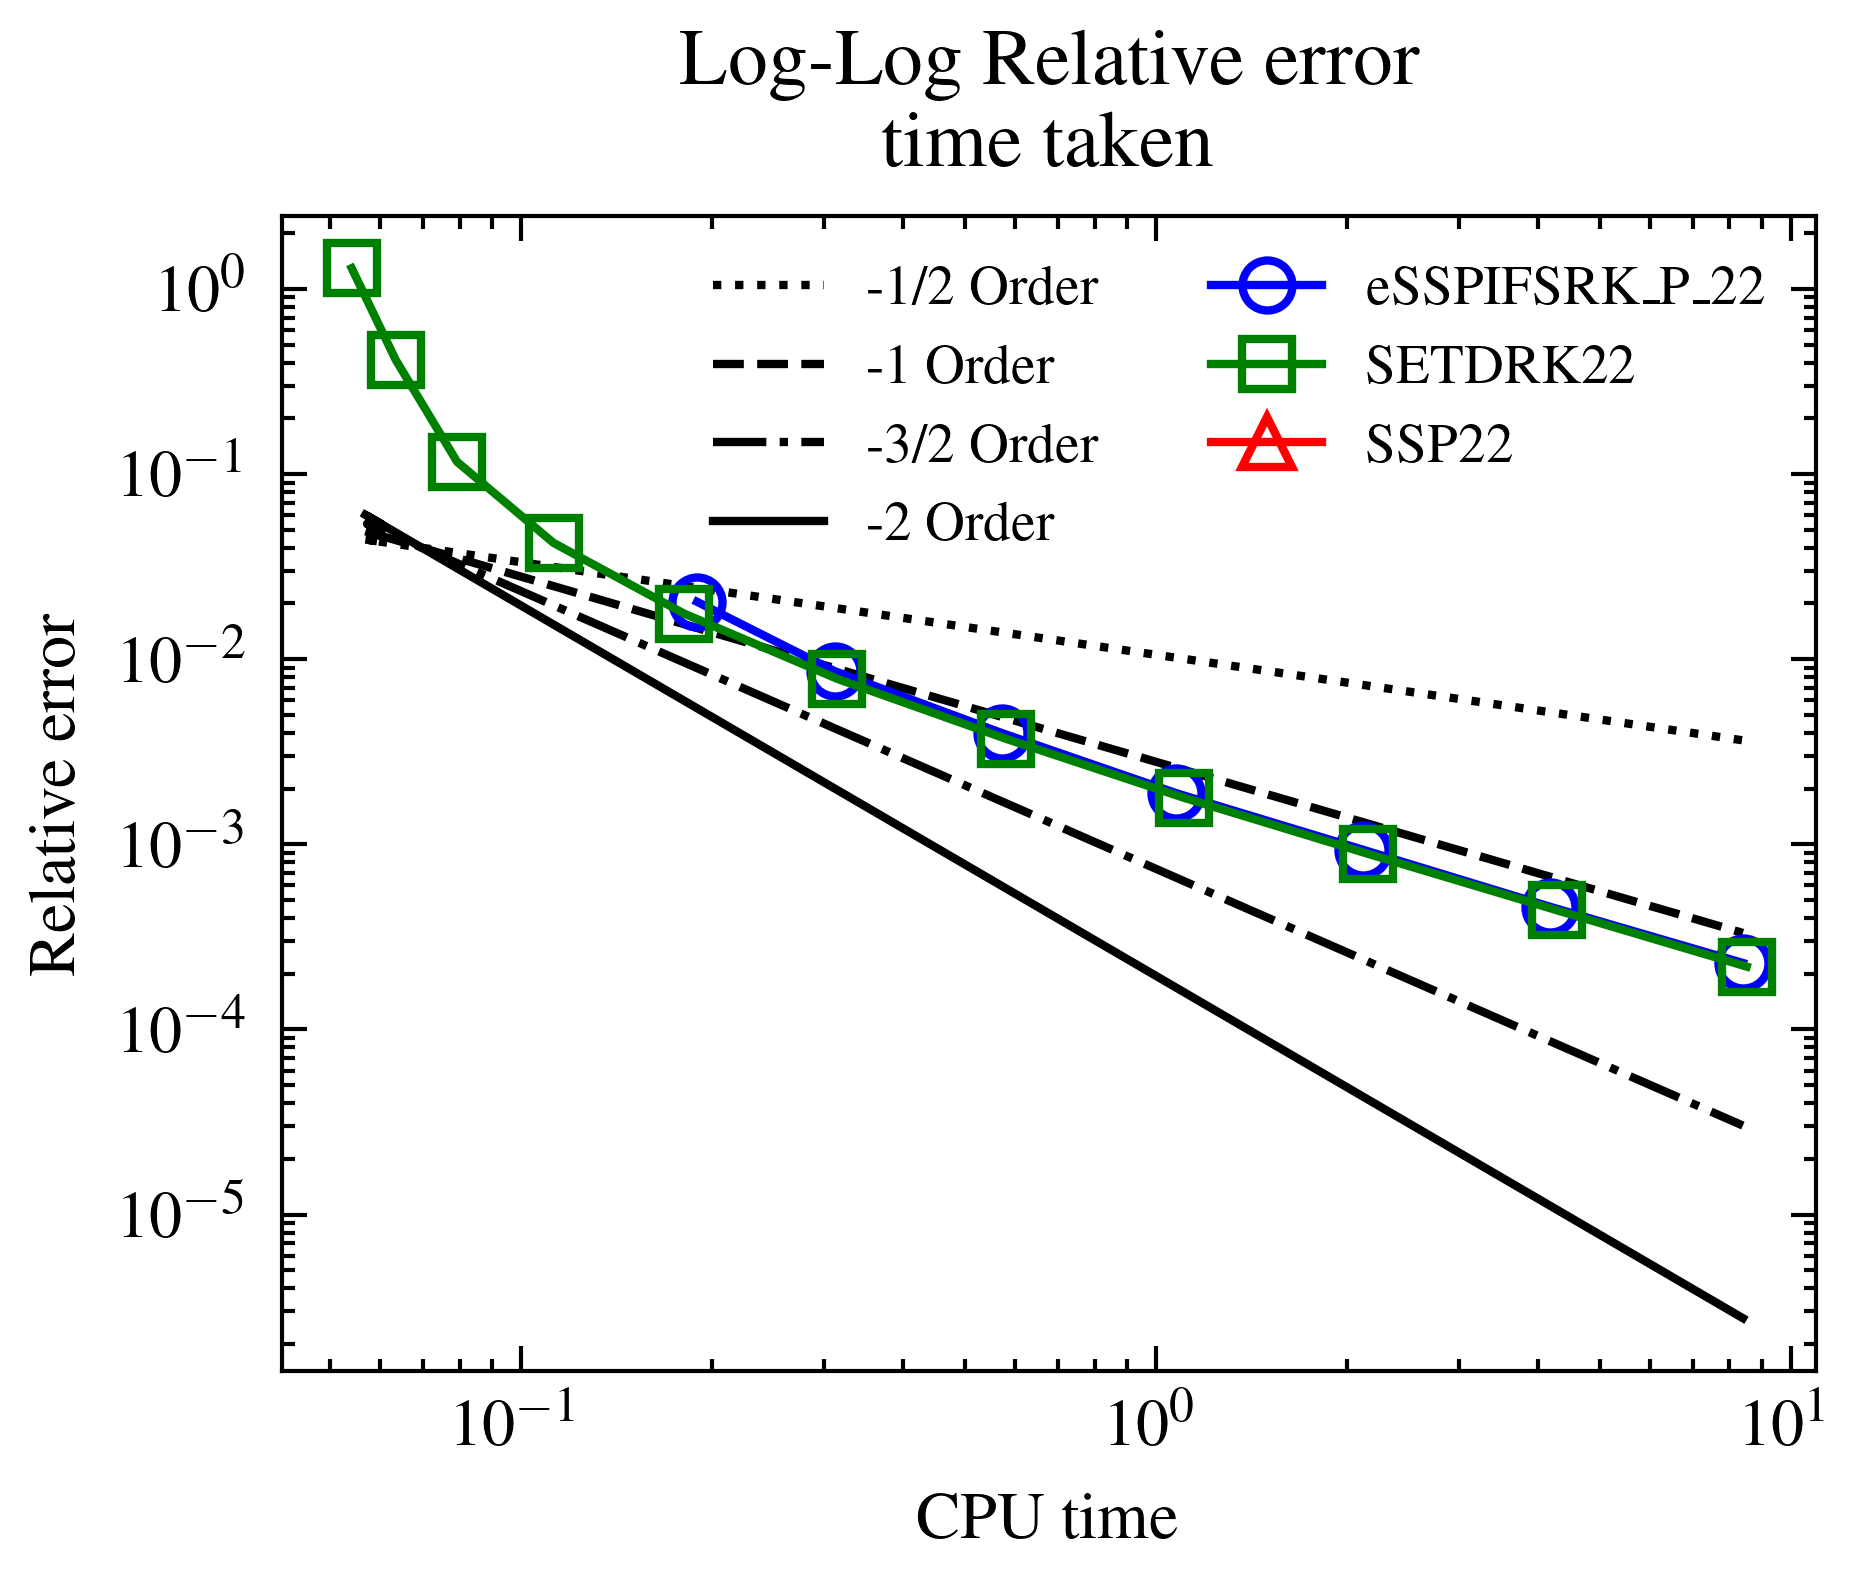

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])
methods = ['Dealiased_eSSPIFSRK_P_22','Dealiased_SETDRK22','Dealiased_SSP22']
values = array
print(values)
print(values.shape)
values = array
print(values,values.shape)
a = cpu_times_array[0,0]
v= 4e-2
plt.figure()
#plt.scatter(a,0.1, color='r', label='point')
# Mask values greater than 1 before plotting
# values = np.where(values > 2, np.nan, values)
plt.loglog(cpu_times_array_3[0,:],(cpu_times_array_3[0,:]**-0.5)/(a**-0.5)*v, linestyle=':', color='k', label=r'-1/2 Order')
plt.loglog(cpu_times_array_3[0,:],(cpu_times_array_3[0,:]**-1)/(a**-1)*v, linestyle='--', color='k', label=r'-1 Order')
plt.loglog(cpu_times_array_3[0,:],(cpu_times_array_3[0,:]**-1.5)/(a**-1.5)*v, linestyle='-.', color='k', label=r'-3/2 Order')
plt.loglog(cpu_times_array_3[0,:],(cpu_times_array_3[0,:]**-2)/(a**-2)*v, linestyle='-', color='k', label=r'-2 Order')

marker_list = ['o', 's', '^', 'D', 'v', 'x', '+', '*', 'p', 'H', 'd', 'X']
color_list = ['b', 'g', 'r', 'c', 'm', 'y']
# In matplotlib, the marker for an upward-pointing triangle is '^'
for j, method in enumerate(methods):
    marker = marker_list[j % len(marker_list)]
    color = color_list[j % len(color_list)]
    plt.loglog(cpu_times_array_3[j,:], values[j, :], marker=marker,color=color, linestyle='-', label=f'{method.replace("Dealiased_", "")}', markerfacecolor='none')

plt.xlabel(f'CPU time')
plt.ylabel('Relative error')
plt.title('Log-Log Relative error \n time taken')
#plt.grid(True, which="both", ls="--")
plt.legend()
plt.legend(fontsize='small', loc='best', ncol=2)
#plt.grid(True, which="both", ls="--")
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/EX5_cpu_error_SSP22_IFRK2_ETD2.png',bbox_inches='tight',dpi=300)
plt.show()




[[           nan            nan            nan            nan
             nan            nan            nan 2.04219690e-02
  8.61473946e-03 3.98933224e-03 1.88852126e-03 9.34314072e-04
  4.60713056e-04 2.28699860e-04]
 [           nan            nan            nan 1.29432850e+00
  4.14862636e-01 1.16385889e-01 4.24932163e-02 1.76342272e-02
  7.82637610e-03 3.72147418e-03 1.78393738e-03 8.88846586e-04
  4.39706553e-04 2.18613942e-04]
 [           nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan]]
(3, 14)
[[           nan            nan            nan            nan
             nan            nan            nan 2.04219690e-02
  8.61473946e-03 3.98933224e-03 1.88852126e-03 9.34314072e-04
  4.60713056e-04 2.28699860e-04]
 [           nan            nan            nan 1.29432850e+00
  4.14862636e-01 1.16385889e-01 4.24932163e-02 1.7634

<Figure size 1980x1500 with 0 Axes>

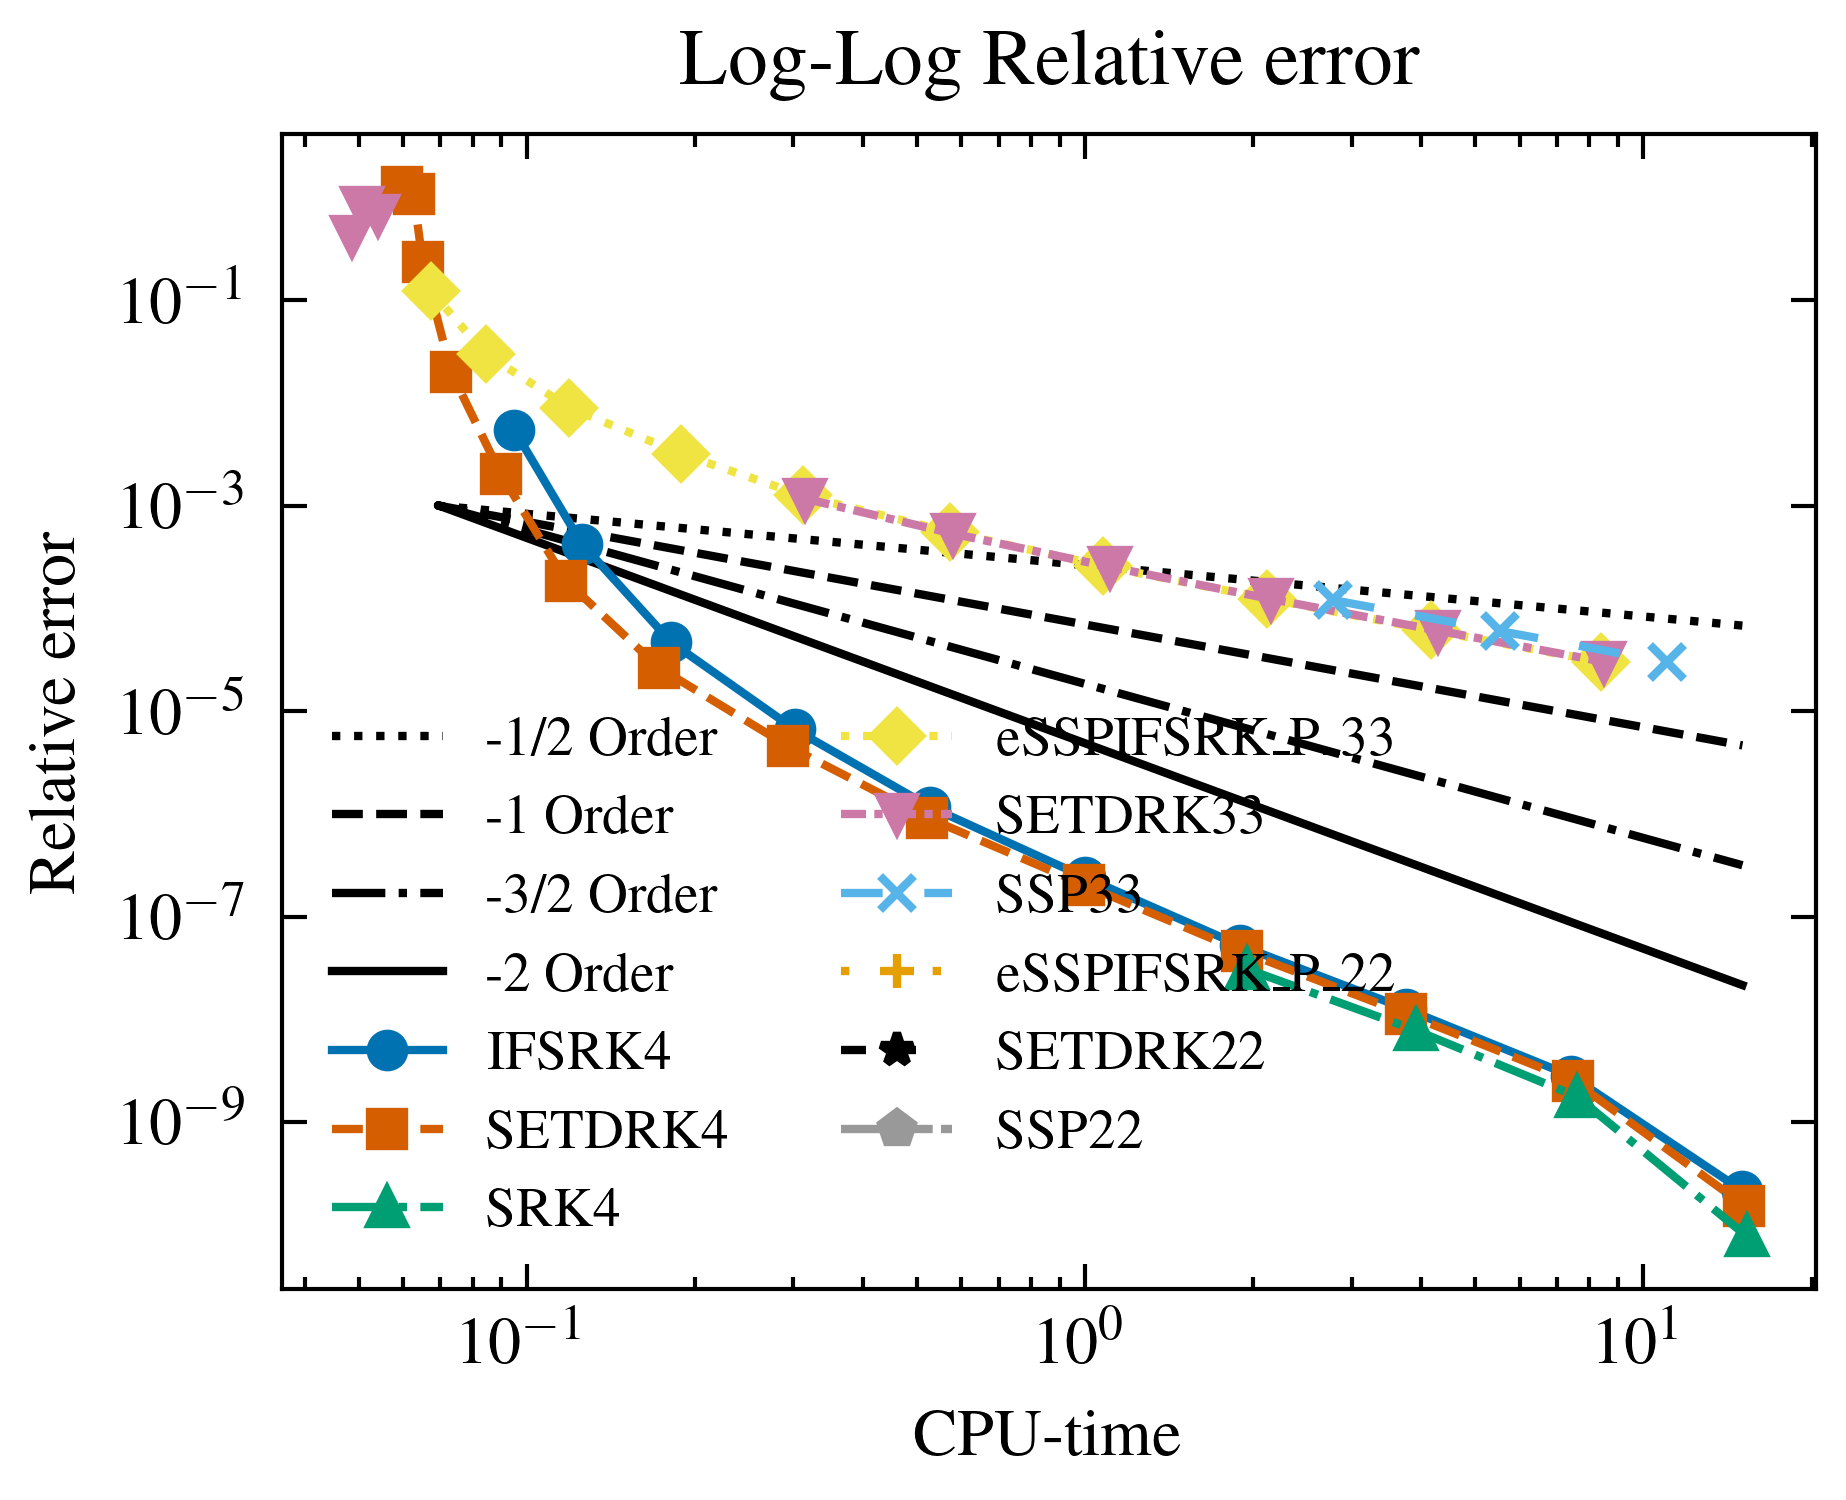

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','ieee'])
plt.clf()
methods = ['Dealiased_IFSRK4','Dealiased_SETDRK4','Dealiased_SRK4',
           'Dealiased_eSSPIFSRK_P_33','Dealiased_SETDRK33','Dealiased_SSP33',
           'Dealiased_eSSPIFSRK_P_22','Dealiased_SETDRK22','Dealiased_SSP22']
max_number = 14
dt = 1e-3*np.asarray([2**-i for i in range(0,max_number)])
values = array
print(values)
print(values.shape)
values = array
print(values,values.shape)
a = cpu_times_array[0,0]#
v= 1e-3#
plt.figure()
#plt.scatter(a,0.1, color='r', label='point')
# Mask values greater than 1 before plotting
values = np.where(values > 1, np.nan, values)
plt.loglog(cpu_times_array[0,:],(cpu_times_array[0,:]**-0.5)/(a**-0.5)*v, linestyle=':', color='k', label=r'-1/2 Order')
plt.loglog(cpu_times_array[0,:],(cpu_times_array[0,:]**-1)/(a**-1)*v, linestyle='--', color='k', label=r'-1 Order')
plt.loglog(cpu_times_array[0,:],(cpu_times_array[0,:]**-1.5)/(a**-1.5)*v, linestyle='-.', color='k', label=r'-3/2 Order')
plt.loglog(cpu_times_array[0,:],(cpu_times_array[0,:]**-2)/(a**-2)*v, linestyle='-', color='k', label=r'-2 Order')


marker_list = ['o', 's', '^', 'D', 'v', 'x', '+', '*', 'p']
# Use a colorblind-friendly palette for better accessibility
color_list = [
    "#0072B2",  # Blue
    "#D55E00",  # Vermillion
    "#009E73",  # Green
    "#F0E442",  # Yellow
    "#CC79A7",  # Purple
    "#56B4E9",  # Sky Blue
    "#E69F00",  # Orange
    "#000000",  # Black
    "#999999"   # Grey
]
#color_list = ["#0d23e8", "#32e80d", "#e81c0d", "#0da6e8", "#c4e80d", "#e85a0d",  "#24a3a5", "#98a524", "#a0792c"]
linestyle_list = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 5)), (0, (1, 10)), (0, (3, 5, 1, 5)), (0, (5, 1))]
# In matplotlib, the marker for an upward-pointing triangle is '^'
for j, method in enumerate(methods):
    marker = marker_list[j % len(marker_list)]
    color = color_list[j % len(color_list)]
    linestyle = linestyle_list[j % len(linestyle_list)]
    plt.loglog(total_cpu_array[j,:], total_array[j, :], marker=marker, color=color, linestyle=linestyle, label=f'{method.replace("Dealiased_", "")}',  markersize=4)
    #plt.loglog(dt, total_array[j, :], marker=marker,color=color, linestyle=linestyle, label=f'{method.replace("Dealiased_", "")}')

plt.xlabel('CPU-time')
plt.ylabel('Relative error')
plt.title('Log-Log Relative error')
#plt.grid(True, which="both", ls="--")
plt.legend()
plt.legend(fontsize='small', loc='best', ncol=2)
#plt.grid(True, which="both", ls="--")

plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/EX5_cpu_time_Allatty.png',bbox_inches='tight',dpi=300)
plt.show()

<Figure size 1980x1500 with 0 Axes>

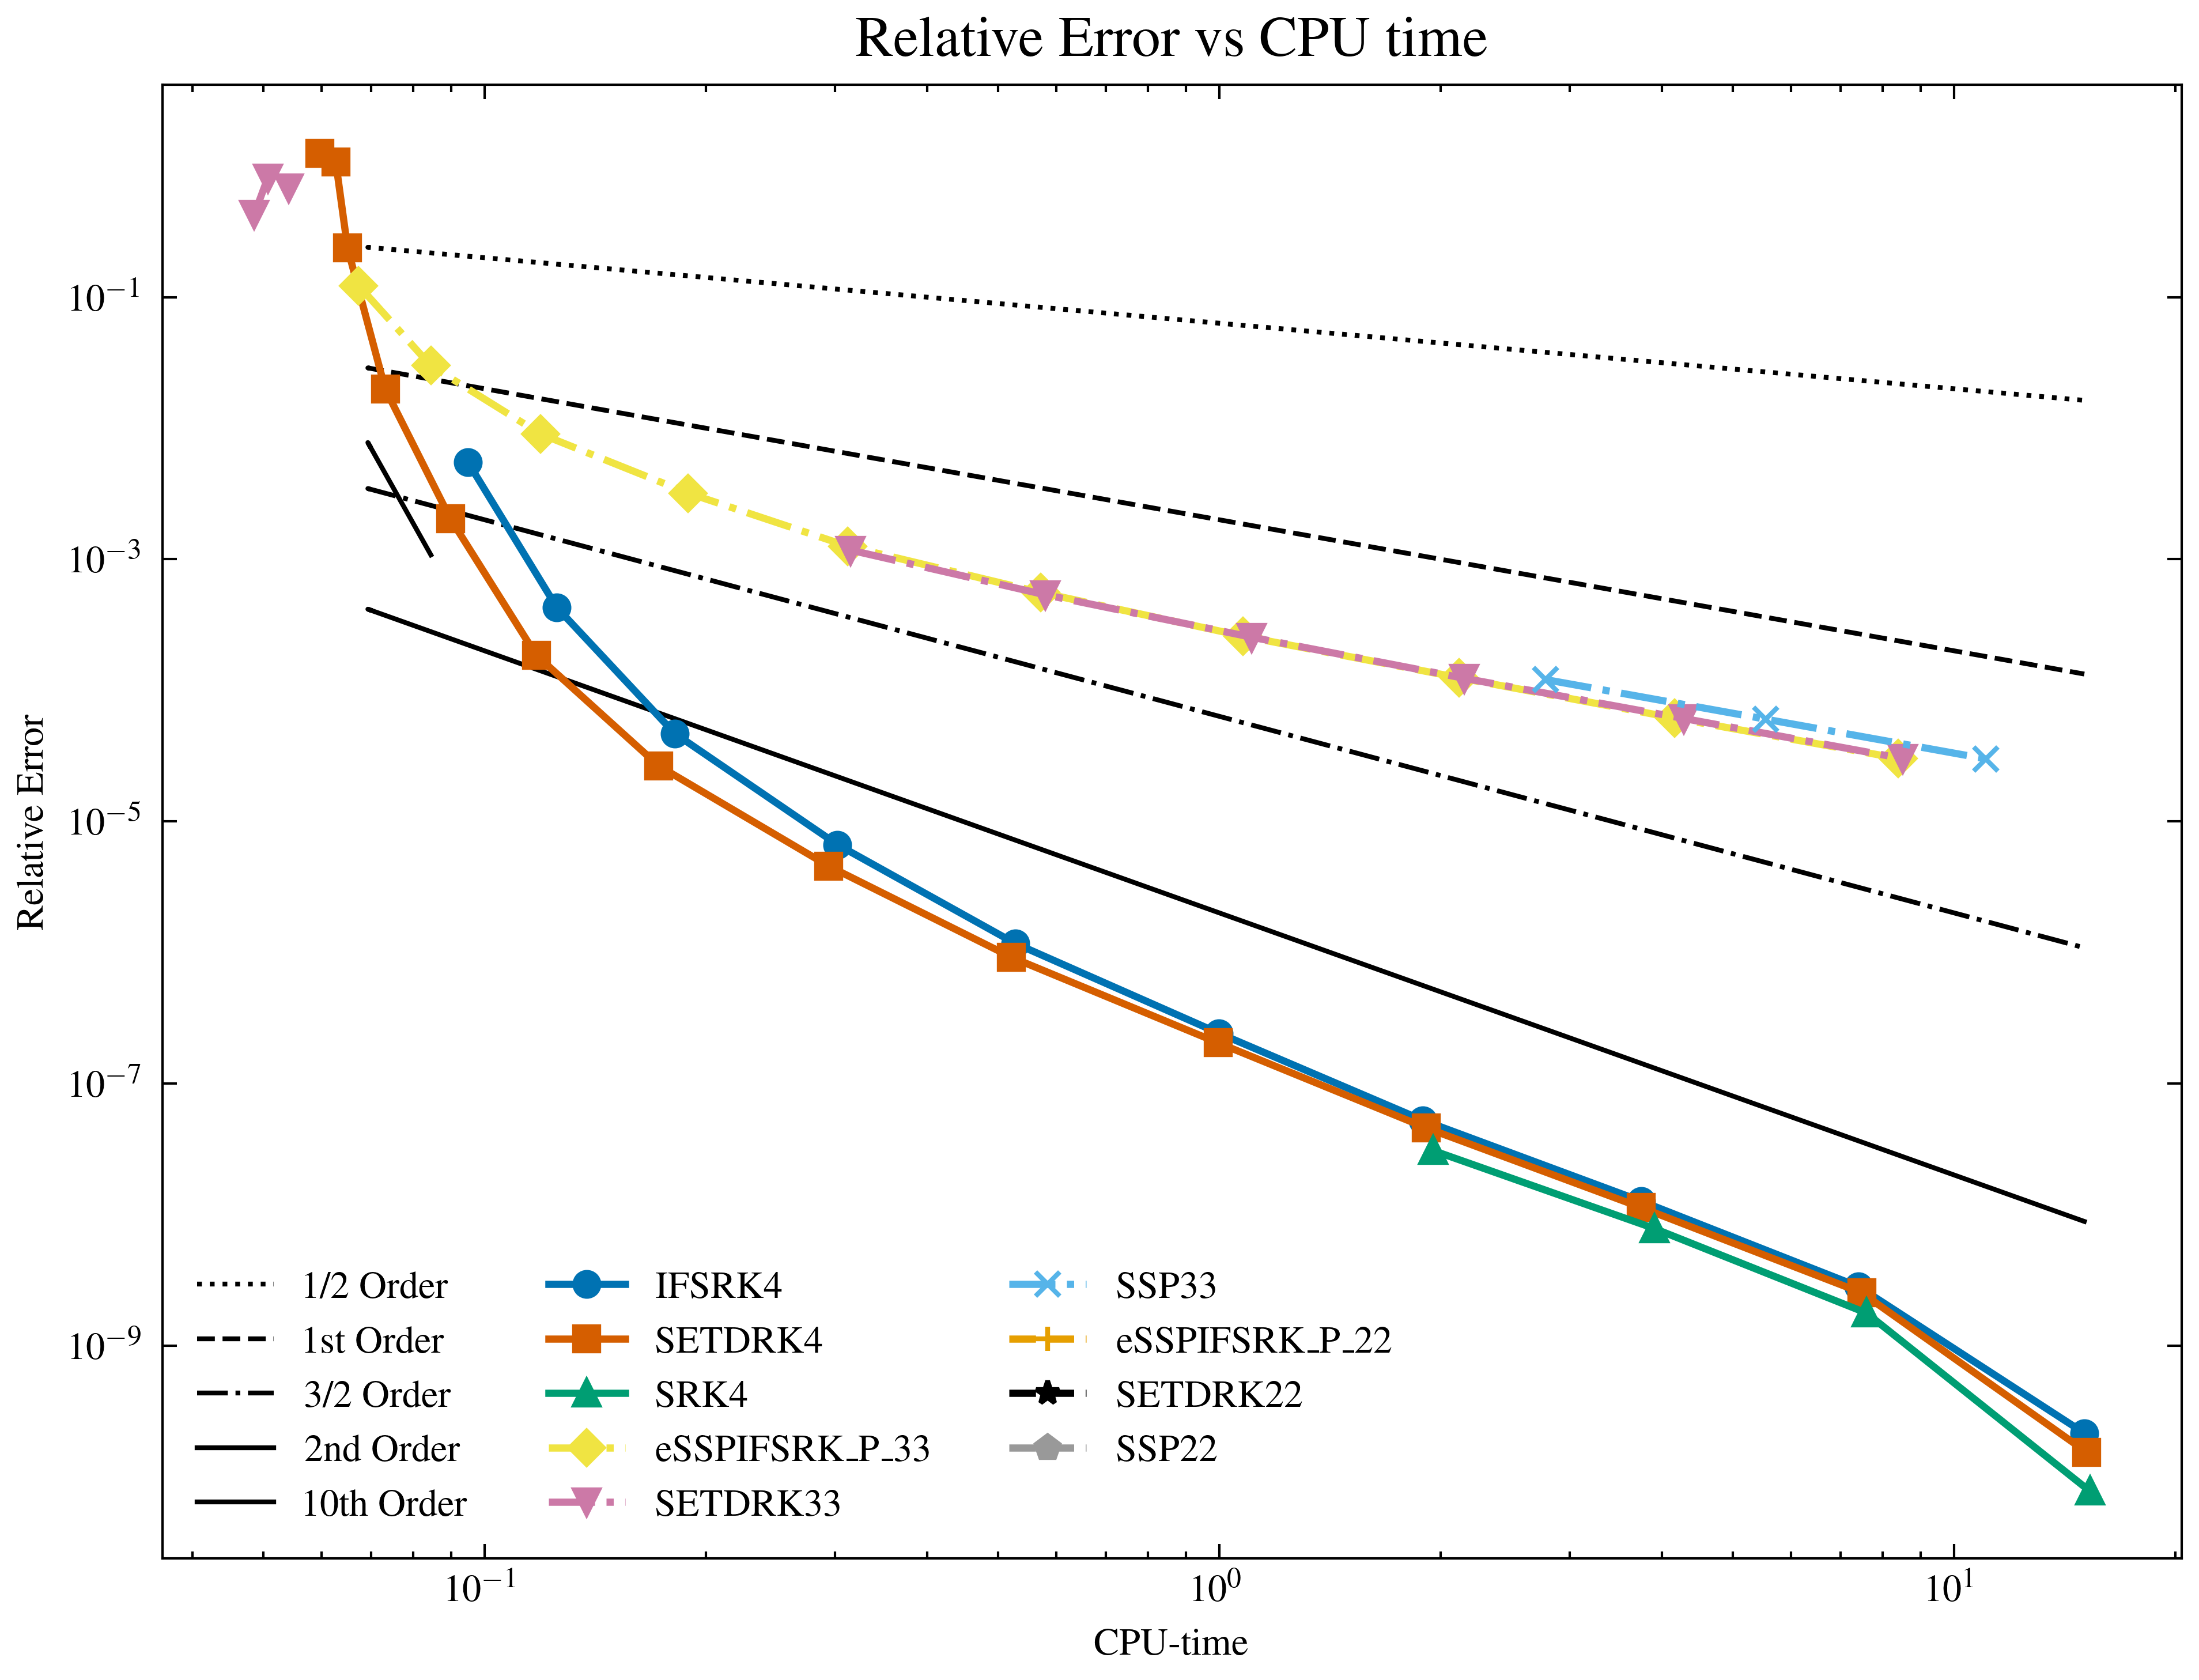

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'ieee'])

# --- Inputs ---
methods = [
    'Dealiased_IFSRK4', 'Dealiased_SETDRK4', 'Dealiased_SRK4',
    'Dealiased_eSSPIFSRK_P_33', 'Dealiased_SETDRK33', 'Dealiased_SSP33',
    'Dealiased_eSSPIFSRK_P_22', 'Dealiased_SETDRK22', 'Dealiased_SSP22'
]

max_number = 14

# Replace this with your actual data (assumed shape [9, max_number])
# Example placeholder (remove once array is loaded):
# total_array = np.random.rand(len(methods), max_number) * (dt**2)[None, :]
# Ensure values and total_array are defined
values = total_array  # If 'array' is the same as 'total_array'

# --- Plot Setup ---
plt.clf()
fig, ax = plt.subplots(figsize=(6.5, 5))  # Slightly wider

# Reference lines for convergence order
a = 1e-3
v = 2
order_styles = {
    r'1/2 Order': (cpu_times_array[0,:]**-0.5)/(a**-0.5)*v,
    r'1st Order': (cpu_times_array[0,:]**-1)/(a**-1)*v,
    r'3/2 Order': (cpu_times_array[0,:]**-1.5)/(a**-1.5)*v,
    r'2nd Order': (cpu_times_array[0,:]**-2)/(a**-2)*v
}
order_linestyles = [':', '--', '-.', '-']
order_colors = ['k']*4
for (label, values), ls, color in zip(order_styles.items(), order_linestyles, order_colors):
    ax.loglog(cpu_times_array[0,:], values, linestyle=ls, color=color, linewidth=1, alpha=1.0, label=label)

    # Plot -4 Order reference line only on a short subinterval near the start
order4_x = cpu_times_array[0, :4]
order4_y = (order4_x**-10)/(a**-10)*v*10e15
ax.loglog(order4_x, order4_y, linestyle='-', color='k', linewidth=1, label='10th Order',alpha=1.0)

# Markers, colors, and linestyles
marker_list = ['o', 's', '^', 'D', 'v', 'x', '+', '*', 'p']
color_list = [
    "#0072B2", "#D55E00", "#009E73", "#F0E442",
    "#CC79A7", "#56B4E9", "#E69F00", "#000000", "#999999"
]
linestyle_list = ['-', '-', '-', '-.','-.','-.', '--', '--', '--']

# Plot each method
for j, method in enumerate(methods):
    label = method.replace("Dealiased_", "")
    marker = marker_list[j % len(marker_list)]
    color = color_list[j % len(color_list)]
    linestyle = linestyle_list[j % len(linestyle_list)]
    ax.loglog(total_cpu_array[j,:], total_array[j, :], marker=marker, linestyle=linestyle,
              color=color, label=label, markersize=5, linewidth=1.5)
# ax.loglog((cpu_times_array[0,:],(cpu_times_array[0,:]**-4)/(a**-4)*v),label='4-th')

# --- Labels, Legend, Title ---
ax.set_xlabel('CPU-time')
ax.set_ylabel('Relative Error')
ax.set_title('Relative Error vs CPU time', fontsize=12)

# Combine and organize legend
ax.legend(fontsize='medium', loc='best', ncol=3, frameon=False)

# Tight layout and save
plt.tight_layout()
plt.savefig('EX5_Temporal_convergence_Allatty.pdf', bbox_inches='tight')  # Vector version
plt.savefig('EX5_Temporal_convergence_Allatty.png', bbox_inches='tight', dpi=300)

plt.show()